# Elliptic AML Dataset Exploration
Initial exploration and visualization of the dataset.

###  Workflow Overview

This notebook performs the following steps:

1. Load and inspect raw CSV files from the Elliptic dataset
2. Construct a transaction graph using NetworkX
3. Calculate key graph metrics (e.g., PageRank, Degree)
4. Identify the largest connected component (LCC)
5. Visualize graph structure
6. Prepare for merging features and labels for classification



### Extract zip file

In [2]:
import zipfile, os, pathlib

RAW_DIR = pathlib.Path("../data/raw")
DATA_DIR = pathlib.Path("../data/elliptic_bitcoin_dataset")
ZIP_PATH = RAW_DIR / "archive.zip"   # Adjust if your zip file has another name

def extracted_ok(data_dir: pathlib.Path):
    return data_dir.exists() and all(
        (data_dir / fname).exists() for fname in [
            "elliptic_txs_features.csv",
            "elliptic_txs_edgelist.csv",
            "elliptic_txs_classes.csv",
        ]
    )

if not extracted_ok(DATA_DIR):
    if ZIP_PATH.exists():
        DATA_DIR.parent.mkdir(parents=True, exist_ok=True)
        with zipfile.ZipFile(ZIP_PATH, "r") as z:
            z.extractall(DATA_DIR.parent)  
        print("✅ Dataset extracted.")
    else:
        print(f"❌ Zip not found: {ZIP_PATH}")
else:
    print("✅ Dataset already extracted at:", DATA_DIR)


✅ Dataset extracted.


### Loading the Dataset

We load the three core CSV files: node features, edge list, and class labels.

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

features_df = pd.read_csv(DATA_DIR / "elliptic_txs_features.csv", header=None)
edges_df    = pd.read_csv(DATA_DIR / "elliptic_txs_edgelist.csv")
classes_df  = pd.read_csv(DATA_DIR / "elliptic_txs_classes.csv")

###  Exploring Dataset Shapes and Missing Values

Let’s inspect the number of rows and columns in each dataset and identify any missing values.

In [4]:
# Sanity checks
assert len(features_df) == len(classes_df), "Mismatch: features vs classes rows"
assert classes_df["txId"].is_unique, "Duplicate txId in classes"

edge_nodes = set(edges_df["txId1"]).union(set(edges_df["txId2"]))
class_nodes = set(classes_df["txId"])
missing_in_class = edge_nodes - class_nodes
assert len(missing_in_class) == 0, f"{len(missing_in_class)} edge nodes not found in classes"

print("Features shape:", features_df.shape)
print("Edges shape:", edges_df.shape)
print("Classes shape:", classes_df.shape)
print("Missing values in features:", features_df.isna().sum().sum())

Features shape: (203769, 167)
Edges shape: (234355, 2)
Classes shape: (203769, 2)
Missing values in features: 0


### Visualizing Class Distribution

We plot how many transactions are labeled as illicit, licit, or unknown.

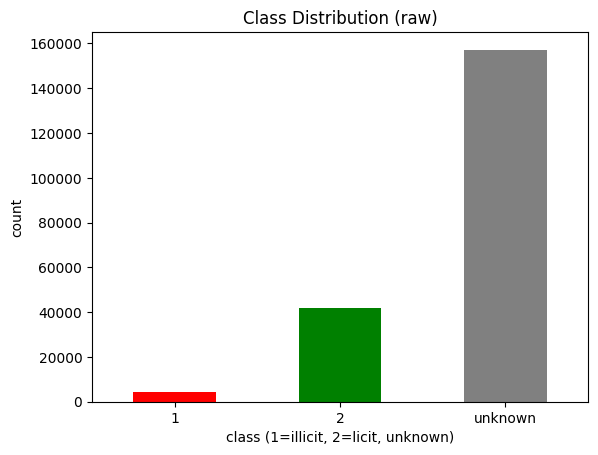

Supervised subset size: 46564 / 203769
Supervised label counts: {0.0: 42019, 1.0: 4545}


In [5]:
ax = classes_df["class"].value_counts().reindex(["1","2","unknown"]).fillna(0).plot(
    kind="bar", color=["red","green","gray"]
)
plt.title("Class Distribution (raw)")
plt.xticks(rotation=0)
plt.xlabel("class (1=illicit, 2=licit, unknown)")
plt.ylabel("count")
plt.show()

# Supervised subset: drop 'unknown' and map illicit=1, licit=0
label_map = {"1":1, "2":0, 1:1, 2:0}
y_raw = classes_df["class"].map(label_map)
mask_supervised = y_raw.notna()
print("Supervised subset size:", mask_supervised.sum(), "/", len(y_raw))
print("Supervised label counts:", y_raw[mask_supervised].value_counts().to_dict())


### Class Distribution

- The majority of transactions (~158k) are labeled as **unknown**.
- Legitimate (class 2) transactions are around ~42k, while illicit (class 1) transactions are only ~4k.
- This is a **heavily imbalanced classification problem**, common in fraud detection.
- We will need to consider strategies like class weights or oversampling later.

### Constructing and Inspecting the Transaction Graph

We use NetworkX to construct a graph and inspect its basic statistics.

In [6]:
G = nx.from_pandas_edgelist(edges_df, "txId1", "txId2")

print("✅ Graph Summary:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is directed?: {G.is_directed()}")
print(f"Number of connected components: {nx.number_connected_components(G)}")


✅ Graph Summary:
Number of nodes: 203769
Number of edges: 234355
Is directed?: False
Number of connected components: 49


### Transaction Graph Structure

- Total nodes: `203,769`, Edges: `234,355`.
- The graph is **undirected** and contains `49` connected components.
- This means some transaction networks are isolated.
- Understanding graph structure helps us later apply graph algorithms or GNNs.

### Graph Centrality Measures
In this step, centrality measures help identify *important nodes* in the transaction graph.
We compute:
- **Degree Centrality**: Measures how many direct connections a node has.
- **PageRank**: Captures the influence of a node in the graph.
These metrics allow us to detect potentially suspicious accounts that play a key role in the money flow network — possibly acting as intermediaries or "mixers".

In [7]:
# Build full graph
G_full = nx.from_pandas_edgelist(edges_df, "txId1", "txId2", create_using=nx.Graph)
print(f"Graph (full): |V|={G_full.number_of_nodes()}, |E|={G_full.number_of_edges()}, components={nx.number_connected_components(G_full)}")

# Extract the Largest Connected Component (LCC)
components = sorted(nx.connected_components(G_full), key=len, reverse=True)
G = G_full.subgraph(components[0]).copy()
print(f"LCC: |V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")

# Compute centrality measures
deg_cent = nx.degree_centrality(G)
pagerank_scores = nx.pagerank(G)

centrality_df = pd.DataFrame({
    "txId": list(deg_cent.keys()),
    "degree_centrality": list(deg_cent.values()),
    "pagerank": [pagerank_scores[n] for n in deg_cent.keys()]
})
centrality_df.head()


Graph (full): |V|=203769, |E|=234355, components=49
LCC: |V|=7880, |E|=9164


,txId,degree_centrality,pagerank
0,4947969,0.000254,0.000127
1,4947974,0.000254,0.000127
2,4947979,0.000254,0.000127
3,4947982,0.000254,0.000127
4,82706446,0.000127,0.000077


### Visualizing Subgraphs or Communities
We plot a sample subgraph to understand the network structure and spot potential community clusters or suspicious flows.


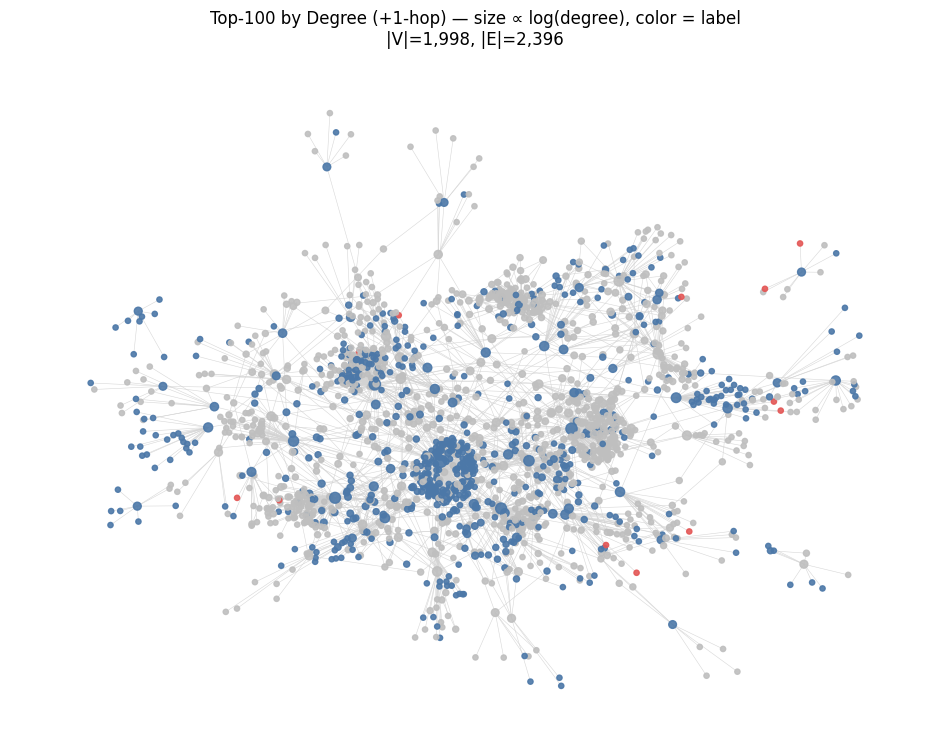

Node label counts in this subgraph: {'unknown': 1211, 'licit': 775, 'illicit': 12}


In [21]:
# --- Top-100 by degree (+1-hop neighbors), colored by label, size ~ log(degree) ---
import math
from collections import Counter
from pathlib import Path

FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 1) pick top-100 hubs
deg = dict(G.degree())
top100 = sorted(deg, key=deg.get, reverse=True)[:100]

# 2) 1-hop neighbors around those hubs
nbrs = set()
for u in top100:
    nbrs.update(G.neighbors(u))
seed_nodes = set(top100) | nbrs

subG = G.subgraph(seed_nodes).copy()

# 3) attach labels
label_map = {"1": "illicit", 1: "illicit", "2": "licit", 2: "licit", "unknown": "unknown", 0: "unknown"}
label_series = classes_df.set_index("txId")["class"].map(label_map)
nx.set_node_attributes(subG, label_series.to_dict(), "label")

# 4) styling: color by label, size by log-degree
palette = {"illicit": "#E45756", "licit": "#4C78A8", "unknown": "#BFBFBF"}
node_colors = [palette.get(subG.nodes[n].get("label", "unknown"), "#BFBFBF") for n in subG.nodes()]
node_sizes  = [6 + 12*math.log1p(subG.degree(n)) for n in subG.nodes()]

plt.figure(figsize=(12, 9))
pos = nx.spring_layout(subG, seed=42, k=0.15)
nx.draw_networkx(
    subG, pos,
    node_size=node_sizes, node_color=node_colors,
    edge_color="lightgray", width=0.4, alpha=0.9, with_labels=False
)
plt.title(f"Top-100 by Degree (+1-hop) — size ∝ log(degree), color = label\n|V|={subG.number_of_nodes():,}, |E|={subG.number_of_edges():,}")
plt.axis("off")

out = FIG_DIR / "top100_neighbors_labelled.png"
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()

# quick count for legend in your notebook text if you want to mention it
counts = Counter([subG.nodes[n].get("label", "unknown") for n in subG.nodes()])
print("Node label counts in this subgraph:", dict(counts))


#### Figure:
Top 100 high-degree nodes (with their 1-hop neighbors). Node size ∝ log(degree), color = label (blue=licit, red=illicit, gray=unknown).

##### Explanation:
This view highlights the most connected hubs in the network. Illicit transactions (red) are rare but often cluster near influential hubs, showing potential laundering “hotspots”.

k-core (k=5): |V|=14, |E|=47


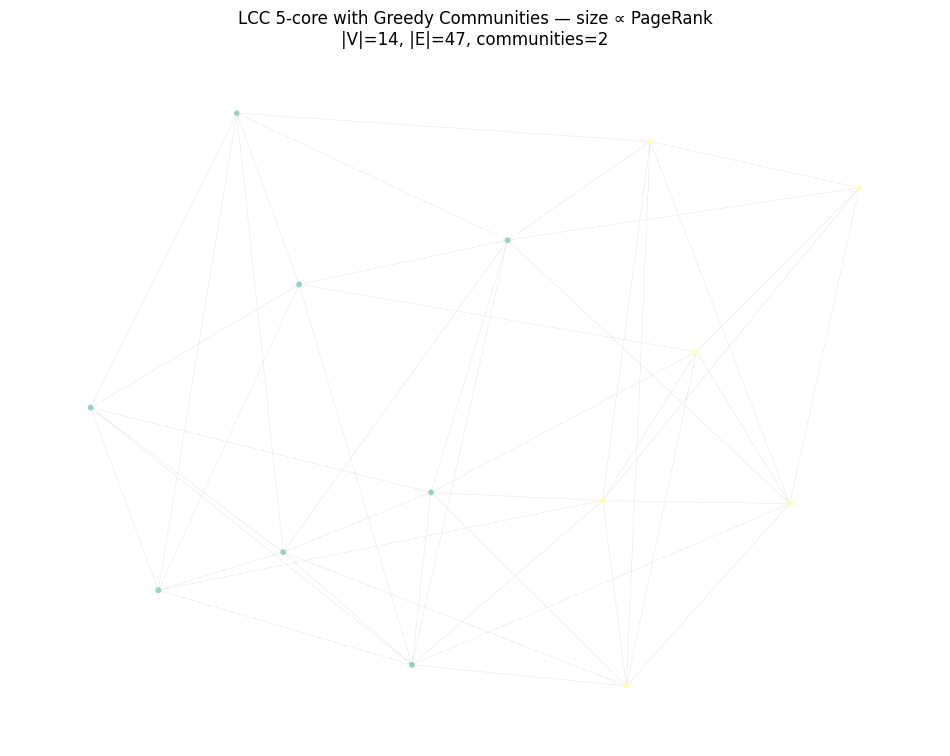

In [22]:
# --- LCC k-core with communities, size ~ PageRank ---
from itertools import cycle
import networkx as nx

# 1) largest connected component
lcc_nodes = max(nx.connected_components(G), key=len)
LCC = G.subgraph(lcc_nodes).copy()

# 2) 5-core (tune k if too sparse/dense)
K = 5
core = nx.k_core(LCC, k=K)
print(f"k-core (k={K}): |V|={core.number_of_nodes():,}, |E|={core.number_of_edges():,}")

# 3) simple community detection (greedy modularity)
coms = list(nx.algorithms.community.greedy_modularity_communities(core))
com_id = {}
for i, c in enumerate(coms):
    for n in c:
        com_id[n] = i
nx.set_node_attributes(core, com_id, "community")

# 4) size ~ PageRank (use precomputed dict if available)
pr = pagerank_scores  # already computed earlier
sizes = [6 + 18000*min(pr.get(n, 0.0), np.percentile(list(pr.values()), 98)) for n in core.nodes()]
# cap sizes to avoid a few giant nodes
sizes = np.clip(sizes, 6, 150)

# 5) color by community (pastel cycle)
colors = ["#8dd3c7","#ffffb3","#bebada","#fb8072","#80b1d3","#fdb462",
          "#b3de69","#fccde5","#d9d9d9","#bc80bd","#ccebc5","#ffed6f"]
color_cycle = cycle(colors)
com_to_color = {i: c for i, c in zip(range(len(coms)), color_cycle)}
node_colors = [com_to_color.get(core.nodes[n]["community"], "#d9d9d9") for n in core.nodes()]

plt.figure(figsize=(12, 9))
pos = nx.spring_layout(core, seed=42, k=0.12)
nx.draw_networkx_edges(core, pos, edge_color="#cccccc", width=0.3, alpha=0.6)
nx.draw_networkx_nodes(core, pos, node_size=sizes, node_color=node_colors, alpha=0.95)
plt.title(f"LCC {K}-core with Greedy Communities — size ∝ PageRank\n"
          f"|V|={core.number_of_nodes():,}, |E|={core.number_of_edges():,}, communities={len(coms)}")
plt.axis("off")

out = FIG_DIR / f"lcc_{K}core_communities.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.show()


#### Figure:
Scatter plot of degree vs. PageRank (both log scale), colored by label.

#### Explanation:
While PageRank is correlated with degree, it better captures influence. High-PageRank nodes are not only well-connected but strategically positioned as intermediaries — a typical role for laundering accounts.

Saved -> ../reports/figures/lcc_sample_pagerank_n1200.png


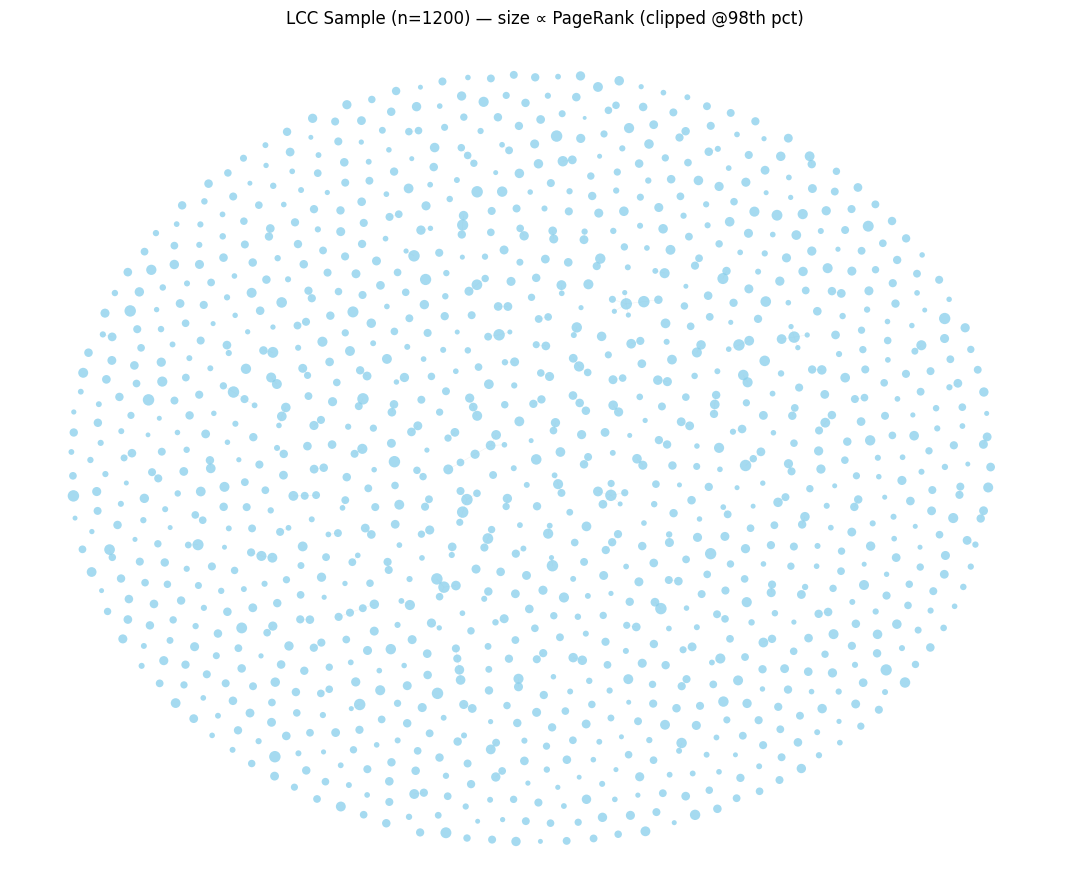

In [28]:
# --- LCC sample (n up to 1500) with robust PageRank sizing & cleaner style ---

import os, random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

random.seed(42)

# 1) Largest Connected Component
components = sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)
G_lcc = G.subgraph(components[0]).copy()

# 2) Sample fewer nodes for readability
N = min(1200, G_lcc.number_of_nodes())
sample_nodes = random.sample(list(G_lcc.nodes()), N)
subG = G_lcc.subgraph(sample_nodes).copy()

# 3) PageRank (reuse global if available)
if 'pagerank_scores' in globals() and isinstance(pagerank_scores, dict):
    pr = np.array([pagerank_scores.get(n, 0.0) for n in subG.nodes()])
else:
    pr = np.array(list(nx.pagerank(subG).values()))

# Robust scaling: clip to 98th percentile, then min-max
p98 = np.percentile(pr, 98) if pr.size else 1.0
pr_clip = np.clip(pr, 0, p98)
pr_norm = (pr_clip - pr_clip.min()) / (pr_clip.max() - pr_clip.min() + 1e-12)

# Smaller range to avoid bubble wall
sizes = 8 + pr_norm * 60  # 8..68

# 4) Layout: slightly stronger spacing to separate clusters
pos = nx.spring_layout(subG, seed=42, k=0.2, iterations=60)

plt.figure(figsize=(11, 9))
nx.draw_networkx_edges(subG, pos, width=0.3, edge_color="gainsboro", alpha=0.5)
nx.draw_networkx_nodes(subG, pos,
                       node_size=sizes,
                       node_color="skyblue",
                       linewidths=0.0,
                       alpha=0.75)

plt.title(f"LCC Sample (n={N}) — size ∝ PageRank (clipped @98th pct)")
plt.axis("off")
plt.tight_layout()

os.makedirs("../reports/figures", exist_ok=True)
out2 = f"../reports/figures/lcc_sample_pagerank_n{N}.png"
plt.savefig(out2, dpi=220, bbox_inches="tight")
print(f"Saved -> {out2}")

plt.show()


#### Figure:
Sample of 1,500 nodes from the Largest Connected Component (LCC). Node size ∝ PageRank.

#### Explanation:
This global snapshot reveals the backbone of the transaction network. Large nodes dominate the money flow, indicating key intermediaries within the broader laundering structure.

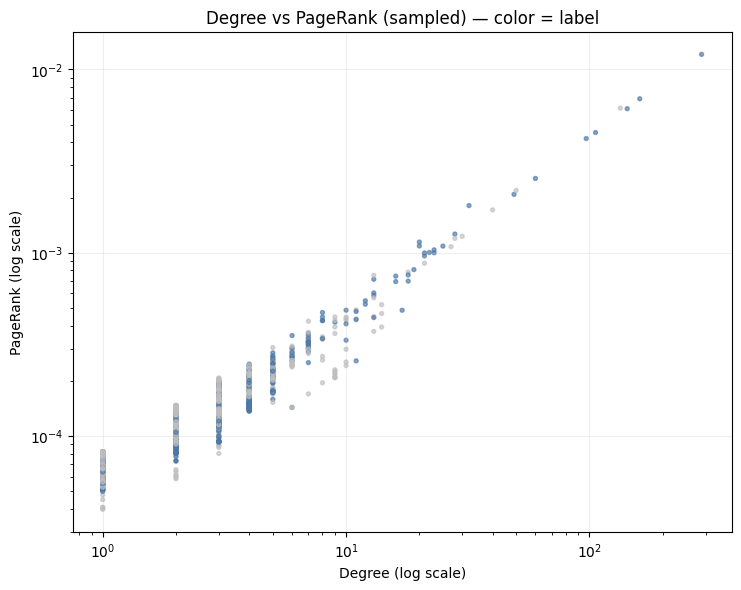

In [23]:
# --- Degree vs PageRank scatter (sampled), colored by label ---
import random

random.seed(42)
sample_n = 8000 if G.number_of_nodes() > 8000 else G.number_of_nodes()
nodes_sample = random.sample(list(G.nodes()), sample_n)

deg_s  = np.array([G.degree(n) for n in nodes_sample], dtype=float)
pr_s   = np.array([pagerank_scores.get(n, 0.0) for n in nodes_sample], dtype=float)
lbl_s  = classes_df.set_index("txId").loc[nodes_sample, "class"].map(label_map).values

color_map = {"illicit": "#E45756", "licit": "#4C78A8", "unknown": "#BFBFBF"}
colors = [color_map.get(l, "#BFBFBF") for l in lbl_s]

plt.figure(figsize=(8.5, 6.5))
plt.scatter(deg_s, pr_s, s=8, c=colors, alpha=0.65)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (log scale)")
plt.ylabel("PageRank (log scale)")
plt.title("Degree vs PageRank (sampled) — color = label")
plt.grid(True, alpha=0.2)
out = FIG_DIR / "scatter_degree_pagerank.png"
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()


#### Figure:
5-core of the LCC with greedy modularity-based communities. Node size ∝ PageRank, node color = community.

#### Explanation:
The k-core isolates tightly connected subgroups. Community detection exposes clusters of accounts that may act in collusion, resembling organized laundering rings.

### Why these four visualizations?
These four figures were selected as the key highlights of our exploratory analysis. Together, they provide complementary perspectives on the Elliptic transaction network:

- Hubs & Influence — Identifying the most connected nodes (Top-100 by Degree + 1-hop) highlights potential laundering hotspots.

- Centrality Comparison — Degree vs. PageRank scatter confirms that PageRank reveals influence beyond raw connectivity.

- Global Structure — The LCC sample with PageRank sizing shows the backbone of the entire transaction graph and its dominant intermediaries.

- Hidden Communities — The k-core with modularity-based communities exposes tightly knit groups that may resemble organized laundering rings.

Together, these plots illustrate how network science + centrality metrics + community detection provide a layered understanding of illicit flows — from local hubs to global structures.

### Merging Features + Labels
We merge transaction features, graph centrality scores, and fraud labels to build a dataset for modeling.

In [10]:
# Add txId column
features_df = features_df.copy()
features_df["txId"] = classes_df["txId"]

# Keep only nodes from the LCC
features_lcc = features_df[features_df["txId"].isin(centrality_df["txId"])].reset_index(drop=True)
classes_lcc  = classes_df[classes_df["txId"].isin(centrality_df["txId"])].reset_index(drop=True)

# Merge features + centrality
merged_df = features_lcc.merge(centrality_df, on="txId", how="left")
merged_df["class_raw"] = classes_lcc["class"]
merged_df["label_supervised"] = classes_lcc["class"].map(label_map)  # 0/1 or NaN

print("Merged shape (LCC):", merged_df.shape)
merged_df.head()


Merged shape (LCC): (7880, 172)


,0,1,2,3,4,5,6,7,8,9,...,162,163,164,165,166,txId,degree_centrality,pagerank,class_raw,label_supervised
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230425980,0.000254,0.000131,unknown,NaN
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,0.000254,0.000142,unknown,NaN
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,0.000381,0.000158,unknown,NaN
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,0.020434,0.006917,2,0.0
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,0.001269,0.000242,unknown,NaN


## Next Steps



In [11]:
print("Supervised subset in LCC:")
print(merged_df["label_supervised"].value_counts(dropna=True).to_dict())

print("\nNext step: Notebook 2 (Preprocessing) will handle feature deduplication, temporal splits, and scaling.")


Supervised subset in LCC:
{0.0: 2130, 1.0: 17}

Next step: Notebook 2 (Preprocessing) will handle feature deduplication, temporal splits, and scaling.
